# Table of Contents | ASD DATA 

- [The BREAST-CANCER dataset](#The-BREAST-CANCER-dataset):
    - [Load the dataset](#Load-the-Dataset)
    - [Explore the dataset: Descriptive statistics](#Explore-the-dataset:-Descriptive-statistics)
    - [Explore the dataset: Visualization](#Explore-the-dataset:-Visualization)
    



The entire project has been based on the following study [Investigating the Correspondence of Clinical  Diagnostic Grouping With Underlying Neurobiological and Phenotypic Clusters Using Unsupervised Machine Learning](https://doi.org/10.1016/j.dib.2018.01.080).

The work focuses on two different pathologies in brain disorders: ASD and ADHD

## The ASD dataset

available at [ABIDE I database](https://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html).


This is .......
 
This data set includes 286 intances (201 of one class, 85 of another class).  The instances are described by 9 attributes, some of which are ordinal and some are nominal.
 
Attribute information

| column | values |
| --- | --- |
| Class | no-recurrence-events, recurrence-events |
| age | 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99|
| menopause | lt40, ge40, premeno|
| tumor-size | 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59|
| inv-nodes | 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39|
| node-caps | yes, no|
| deg-malig | 1, 2, 3|
| breast | left, right|
| breast-quad | left-up, left-low, right-up, right-low, central|
| irradiat | yes, no|
 
There are 9 Missing Attribute Values (denoted by "?") 


In [38]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt #for the plots
import seaborn as sns 

In [39]:
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD','ASD_phenotypic.csv'))

In [40]:
#visualizziamo, non completamente, il nostro dataset
#e otteniamone la dimensione: prima info utile
ASD_phenotypic

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_INTERPERSONAL_V_SCALED,VINELAND_PLAY_V_SCALED,VINELAND_COPING_V_SCALED,VINELAND_SOCIAL_STANDARD,VINELAND_SUM_SCORES,VINELAND_ABC_STANDARD,VINELAND_INFORMANT,WISC_IV_VCI,WISC_IV_PRI,WISC_IV_WMI,WISC_IV_PSI,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.40,1,R,NaN,126.0,118.0,128.0,WASI,WASI,WASI,-9999.0,-9999.0,-9999.0,-9999.0,NaN,4.0,9.0,2.0,7.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.90,1,Ambi,NaN,107.0,119.0,93.0,WASI,WASI,WASI,23.0,17.0,5.0,3.0,1.0,4.0,8.0,3.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.20,1,R,NaN,93.0,80.0,108.0,WASI,WASI,WASI,13.0,18.0,7.0,4.0,1.0,4.0,20.0,6.0,14.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.80,1,R,NaN,106.0,94.0,118.0,WASI,WASI,WASI,12.0,12.0,2.0,1.0,1.0,4.0,12.0,4.0,8.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.60,2,Ambi,NaN,133.0,135.0,122.0,WASI,WASI,WASI,21.0,11.0,6.0,3.0,1.0,4.0,13.0,4.0,9.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,50624,1,3,11.08,2,R,NaN,90.0,91.0,89.0,DAS_II_SA,DAS_II_SA,DAS_II_SA,7.0,10.0,4.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,6.0,2.0,8.0,5.0,1.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1108,YALE,50625,1,3,7.00,1,L,NaN,99.0,90.0,98.0,DAS_II_SA,DAS_II_SA,DAS_II_SA,26.0,23.0,4.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,6.0,3.0,9.0,6.0,1.0,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1109,YALE,50626,1,3,11.08,1,L,NaN,61.0,66.0,60.0,DAS_II_SA,DAS_II_SA,DAS_II_SA,24.0,24.0,6.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,18.0,7.0,25.0,10.0,-9999.0,-9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [41]:
ASD_phenotypic.head() #in order to underline features

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_INTERPERSONAL_V_SCALED,VINELAND_PLAY_V_SCALED,VINELAND_COPING_V_SCALED,VINELAND_SOCIAL_STANDARD,VINELAND_SUM_SCORES,VINELAND_ABC_STANDARD,VINELAND_INFORMANT,WISC_IV_VCI,WISC_IV_PRI,WISC_IV_WMI,WISC_IV_PSI,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.4,1,R,NaN,126.0,118.0,128.0,WASI,WASI,WASI,-9999.0,-9999.0,-9999.0,-9999.0,NaN,4.0,9.0,2.0,7.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.9,1,Ambi,NaN,107.0,119.0,93.0,WASI,WASI,WASI,23.0,17.0,5.0,3.0,1.0,4.0,8.0,3.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.2,1,R,NaN,93.0,80.0,108.0,WASI,WASI,WASI,13.0,18.0,7.0,4.0,1.0,4.0,20.0,6.0,14.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.8,1,R,NaN,106.0,94.0,118.0,WASI,WASI,WASI,12.0,12.0,2.0,1.0,1.0,4.0,12.0,4.0,8.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.6,2,Ambi,NaN,133.0,135.0,122.0,WASI,WASI,WASI,21.0,11.0,6.0,3.0,1.0,4.0,13.0,4.0,9.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


In [42]:
#otteniamo le informazioni relative al dataset
ASD_phenotypic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SITE_ID                          1112 non-null   object 
 1   SUB_ID                           1112 non-null   int64  
 2   DX_GROUP                         1112 non-null   int64  
 3   DSM_IV_TR                        1112 non-null   int64  
 4   AGE_AT_SCAN                      1112 non-null   float64
 5   SEX                              1112 non-null   int64  
 6   HANDEDNESS_CATEGORY              797 non-null    object 
 7   HANDEDNESS_SCORES                370 non-null    float64
 8   FIQ                              1077 non-null   float64
 9   VIQ                              935 non-null    float64
 10  PIQ                              953 non-null    float64
 11  FIQ_TEST_TYPE                    947 non-null    object 
 12  VIQ_TEST_TYPE       

#  CATEGORICAL EXPLORATION

In [43]:
#vogliamo individuare e capire cosa sono questi object
objects = ASD_phenotypic.select_dtypes(include=['object'])
objects.T

0        1        2        3        4        5     \
SITE_ID              CALTECH  CALTECH  CALTECH  CALTECH  CALTECH  CALTECH   
HANDEDNESS_CATEGORY        R     Ambi        R        R     Ambi        R   
FIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
VIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
PIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
COMORBIDITY              NaN      NaN      NaN      NaN      NaN      NaN   
CURRENT_MED_STATUS       NaN      NaN      NaN      NaN      NaN      NaN   
MEDICATION_NAME          NaN      NaN      NaN      NaN      NaN      NaN   

                        6        7        8        9        10       11    \
SITE_ID              CALTECH  CALTECH  CALTECH  CALTECH  CALTECH  CALTECH   
HANDEDNESS_CATEGORY        R        R     Ambi        R     Ambi        R   
FIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WAIS     WISC   
VIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WAIS     WISC   
PIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WAIS     WISC   
COMORBIDITY              NaN      NaN      NaN      NaN      NaN      NaN   
CURRENT_MED_STATUS       NaN      NaN      NaN      NaN      NaN      NaN   
MEDICATION_NAME          NaN      NaN      NaN      NaN      NaN      NaN   

                        12       13       14       15       16       17    \
SITE_ID              CALTECH  CALTECH  CALTECH  CALTECH  CALTECH  CALTECH   
HANDEDNESS_CATEGORY        R        R        R        R     Ambi        R   
FIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
VIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
PIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
COMORBIDITY              NaN      NaN      NaN      NaN      NaN      NaN   
CURRENT_MED_STATUS       NaN      NaN      NaN      NaN      NaN      NaN   
MEDICATION_NAME          NaN      NaN      NaN      NaN      NaN      NaN   

                        18       19       20       21       22       23    \
SITE_ID              CALTECH  CALTECH  CALTECH  CALTECH  CALTECH  CALTECH   
HANDEDNESS_CATEGORY        R        R        R        R        R        R   
FIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
VIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
PIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
COMORBIDITY              NaN      NaN      NaN      NaN      NaN      NaN   
CURRENT_MED_STATUS       NaN      NaN      NaN      NaN      NaN      NaN   
MEDICATION_NAME          NaN      NaN      NaN      NaN      NaN      NaN   

                        24       25       26       27       28       29    \
SITE_ID              CALTECH  CALTECH  CALTECH  CALTECH  CALTECH  CALTECH   
HANDEDNESS_CATEGORY        R        R        R     Ambi        R        R   
FIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
VIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
PIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
COMORBIDITY              NaN      NaN      NaN      NaN      NaN      NaN   
CURRENT_MED_STATUS       NaN      NaN      NaN      NaN      NaN      NaN   
MEDICATION_NAME          NaN      NaN      NaN      NaN      NaN      NaN   

                        30       31       32       33       34       35    \
SITE_ID              CALTECH  CALTECH  CALTECH  CALTECH  CALTECH  CALTECH   
HANDEDNESS_CATEGORY     Ambi        R        L        R        R        R   
FIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
VIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
PIQ_TEST_TYPE           WASI     WASI     WASI     WASI     WASI     WASI   
COMORBIDITY              NaN      NaN      NaN      NaN      NaN      NaN   
CURRENT_MED_STA

To understand better how to treat the information gived by this categorical variables we are interested in know which values are stored in this features. We will analyze all of them.

## Handling categorical variables

In [44]:
#attraverserà ogni colonna nel DataFrame objects, che contiene solo le colonne di tipo 
#'object', e per ciascuna colonna stampa il nome della feature, il numero di valori unici,
#i valori unici stessi e il numero di valori mancanti (NaN)


#for column in objects.columns:
 #   print("Nome della feature:", column)
  #  unique_values = objects[column].unique()  # Ottieni i valori unici
   # nan_count = objects[column].isnull().sum()  # Conta i valori mancanti
    #print("Numero di valori unici:", len(unique_values))
    #print("Valori unici:")
    #for value in unique_values:
      #  print("-", value)
    #print("Numero di valori mancanti (NaN):", nan_count)
    #print("----------------------------------")

In [45]:
'''In questo modo otterrai un dataframe dove ogni colonna rappresenta una feature
di tipo "object" e ogni riga rappresenta un valore unico trovato in quella feature,
insieme alla sua frequenza. Puoi quindi esplorare facilmente questo dataframe per vedere
i valori unici associati a ciascuna feature.'''

# Creazione di un dizionario vuoto per memorizzare i valori unici di ogni feature di tipo "object"
unique_values_dict = {}

# Iterazione attraverso tutte le colonne di tipo "object"
for column_name in objects.columns:
    # Ottieni i valori unici e le loro frequenze per la colonna corrente
    unique_values_counts = objects[column_name].value_counts(dropna=False)
    # Aggiungi i valori unici e le loro frequenze al dizionario usando il nome della colonna come chiave
    unique_values_dict[column_name] = unique_values_counts

# Converti il dizionario in un dataframe pandas
unique_values_df = pd.DataFrame(unique_values_dict)

# Visualizza il dataframe dei valori unici per le colonne di tipo "object"
print(unique_values_df)

                                                    SITE_ID  \
-9999                                                   NaN   
0                                                       NaN   
1                                                       NaN   
ADHD                                                    NaN   
ADHD (inattentive; present); ODD; MDE (past); P...      NaN   
...                                                     ...   
`                                                       NaN   
ppvt                                                    NaN   
ravens                                                  NaN   
simple phobia- bridges                                  NaN   
NaN                                                     NaN   

                                                    HANDEDNESS_CATEGORY  \
-9999                                                              11.0   
0                                                                   NaN   
1                 

In [46]:
'''Per accedere alle singole feature nel dataframe unique_values_df,
puoi utilizzare il nome della colonna come indice. Ecco alcuni esempi:

python
Copy code
# Accesso alla feature 'feature1'
feature1_unique_values = unique_values_df['feature1']

# Accesso alla feature 'feature2'
feature2_unique_values = unique_values_df['feature2']

# Accesso alla feature 'feature3'
feature3_unique_values = unique_values_df['feature3']

# E così via...
In questo modo, feature1_unique_values, feature2_unique_values, ecc. conterranno una serie pandas che rappresenta i valori unici e le loro frequenze per la rispettiva feature. Puoi quindi utilizzare i metodi e gli attributi delle serie pandas per esplorare ulteriormente questi valori.

'''

"Per accedere alle singole feature nel dataframe unique_values_df,\npuoi utilizzare il nome della colonna come indice. Ecco alcuni esempi:\n\npython\nCopy code\n# Accesso alla feature 'feature1'\nfeature1_unique_values = unique_values_df['feature1']\n\n# Accesso alla feature 'feature2'\nfeature2_unique_values = unique_values_df['feature2']\n\n# Accesso alla feature 'feature3'\nfeature3_unique_values = unique_values_df['feature3']\n\n# E così via...\nIn questo modo, feature1_unique_values, feature2_unique_values, ecc. conterranno una serie pandas che rappresenta i valori unici e le loro frequenze per la rispettiva feature. Puoi quindi utilizzare i metodi e gli attributi delle serie pandas per esplorare ulteriormente questi valori.\n\n"

In [47]:
for column_name in objects.columns:
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    # Get and display unique values and their frequencies
    print("Unique values in column", column_name, "and their frequencies:")
    unique_values_counts = objects[column_name].value_counts(dropna=False)
    print(unique_values_counts)
    print("__________________________________________\n") #to separate features
    #FAI MATRICE O FILE DI STORAGE 

    #N.B. come output
    #"Name: count, dtype: int64" non fa parte dei risultati effettivi dei valori unici e dei loro conteggi, ma è solo una rappresentazione dell'indice della Serie e del tipo di dato dei suoi valori. Quindi, puoi ignorare questo messaggio se stai cercando solo i valori unici e i loro conteggi.

Unique values in column SITE_ID and their frequencies:
SITE_ID
NYU         184
UM_1        110
USM         101
UCLA_1       82
MAX_MUN      57
PITT         57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
LEUVEN_2     35
UM_2         35
SBL          30
LEUVEN_1     29
OHSU         28
CMU          27
UCLA_2       27
Name: count, dtype: int64
__________________________________________

Unique values in column HANDEDNESS_CATEGORY and their frequencies:
HANDEDNESS_CATEGORY
R        693
NaN      315
L         71
Ambi      15
-9999     11
Mixed      6
L->R       1
Name: count, dtype: int64
__________________________________________

Unique values in column FIQ_TEST_TYPE and their frequencies:
FIQ_TEST_TYPE
WASI                  551
NaN                   165
WISC_IV_FULL          103
WAIS_III               63
DAS_II_SA              56
WST                    41
WISC_III_DUTCH         35
WISC_IV_4_SUBTESTS     33
WISC            

Exploding categorical features, we notice the presesence of value -9999, used to denoted missing data or values out of range, so we are going to consider them as NaN. Globalmente.

In [48]:
# Sostituisci il valore -9999 con NaN in tutto il DataFrame
ASD_phenotypic.replace([-9999, "-9999"], np.nan, inplace=True)
#ASD_phenotypic

In [49]:
'''from sklearn.preprocessing import LabelEncoder

# Inizializza il LabelEncoder
label_encoder = LabelEncoder()

# Applica il LabelEncoder a ciascuna feature di tipo object
for column in objects.columns:
    ASD_phenotypic[column] = label_encoder.fit_transform(ASD_phenotypic[column])

    mapping = {'R': 100, 'L': -100, 'Ambi': 0, 'Mixed': 0, 'L->R': 0}

# Replace values in the specified column
    ASD_phenotypic[column_name] = ASD_phenotypic[column_name].replace(mapping)
ASD_phenotypic'''



"from sklearn.preprocessing import LabelEncoder\n\n# Inizializza il LabelEncoder\nlabel_encoder = LabelEncoder()\n\n# Applica il LabelEncoder a ciascuna feature di tipo object\nfor column in objects.columns:\n    ASD_phenotypic[column] = label_encoder.fit_transform(ASD_phenotypic[column])\n\n    mapping = {'R': 100, 'L': -100, 'Ambi': 0, 'Mixed': 0, 'L->R': 0}\n\n# Replace values in the specified column\n    ASD_phenotypic[column_name] = ASD_phenotypic[column_name].replace(mapping)\nASD_phenotypic"

### SITE_ID

SITE_ID refers to the place where the data from the subject was recluted. As we are not interested in include the place of analysis as a feature for our clustering algorithm, we can decide to drop this column.

However, this information could be retrieved in posteriori analysis if we are interesting in analysing the variability for the results taking the specific site information. 
(? sound like a good explanation??)

In [50]:
#column_name = 'SITE_ID'

# Get unique values and their frequencies
##unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
#print("Unique values in column '{}' and their frequencies:".format(column_name))
#for value, count in unique_values_counts.items():
#    print("{}: {}".format(value, count))

### HANDEDNESS_CATEGORY

HANDEDNESS_CATEGORY refers to the handedness of the subject. We don't really know if there is a correlation or not between the Autism Disease and the handnedness of the subject and as it is a caracteristic of the subject itselfs and not of the specific site of analysis as in the previous case, we decide to work with this feature.

In [51]:
column_name = 'HANDEDNESS_CATEGORY'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'HANDEDNESS_CATEGORY' and their frequencies:
R: 693
nan: 326
L: 71
Ambi: 15
Mixed: 6
L->R: 1


We can see that we have values for R, L and Ambi, Mixed, L->R. The dataset include as a feature also a handness score where right-handed subjects has positive score (max = 100), lef-handed subjects negative score (min = -100) and ambidextreus subjects has 0 score. 

To be coherent with that categorization and can properly evaluate if one of those features contain redudant information or that can be merged in some manner, we decide to assign to R values the number "100", to L values the number "-100" and to Ambi, Mixed, L->R the number "0".

In [52]:
mapping = {'R': 100, 'L': -100, 'Ambi': 0, 'Mixed': 0, 'L->R': 0}

# Replace values in the specified column
ASD_phenotypic[column_name] = ASD_phenotypic[column_name].replace(mapping)

#Now we display the new result
# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'HANDEDNESS_CATEGORY' and their frequencies:
100.0: 693
nan: 326
-100.0: 71
0.0: 22


C:\Users\auran\AppData\Local\Temp\ipykernel_12376\3725085334.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ASD_phenotypic[column_name] = ASD_phenotypic[column_name].replace(mapping)


### FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE

FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE refers to the type of test that each center chose to get the information of FIQ_TEST, VIQ_TEST and PIQ_TEST respectively. As we want our clustering algorithm to be as most general as possible, we want to be able to categorize subjects in despise of the test used by the centers to get the data. So we decide to drop this feature as well.

Note that if in a future we will be interested in to analyze if there are differences between the clustering score obtained using the result for each difference test we'll can retrieve the information opportunely.

In [53]:
column_name = 'FIQ_TEST_TYPE'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'FIQ_TEST_TYPE' and their frequencies:
WASI: 551
nan: 169
WISC_IV_FULL: 103
WAIS_III: 63
DAS_II_SA: 56
WST: 41
WISC_III_DUTCH: 35
WISC_IV_4_SUBTESTS: 33
WISC: 28
WISC_III: 15
HAWIK_IV: 14
WAIS: 3
GIT: 1


In [54]:
column_name = 'VIQ_TEST_TYPE'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'VIQ_TEST_TYPE' and their frequencies:
WASI: 508
nan: 278
PPVT: 94
DAS_II_SA: 69
WISC_IV_FULL: 47
WAIS_III: 43
WISC: 28
PPVT    : 24
GIT: 8
WASI    : 5
WAIS: 3
ppvt: 2
WISC4   : 1
Stanford: 1
WISC_III: 1


In [55]:
column_name = 'PIQ_TEST_TYPE'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'PIQ_TEST_TYPE' and their frequencies:
WASI: 508
nan: 259
Ravens: 103
DAS_II_SA: 70
WISC_IV_FULL: 47
WAIS_III: 43
WISC: 28
RAVENS: 22
Ravens  : 11
GIT: 8
WASI    : 5
WAIS: 3
ravens: 2
WISC4   : 1
Stanford: 1
WISC_III: 1


In [56]:
for index, row in objects.T.iterrows():
    values=row.value_counts(dropna=False)
    print(values)

SITE_ID
NYU         184
UM_1        110
USM         101
UCLA_1       82
MAX_MUN      57
PITT         57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
LEUVEN_2     35
UM_2         35
SBL          30
LEUVEN_1     29
OHSU         28
CMU          27
UCLA_2       27
Name: count, dtype: int64
HANDEDNESS_CATEGORY
R        693
NaN      315
L         71
Ambi      15
-9999     11
Mixed      6
L->R       1
Name: count, dtype: int64
FIQ_TEST_TYPE
WASI                  551
NaN                   165
WISC_IV_FULL          103
WAIS_III               63
DAS_II_SA              56
WST                    41
WISC_III_DUTCH         35
WISC_IV_4_SUBTESTS     33
WISC                   28
WISC_III               15
HAWIK_IV               14
-9999                   4
WAIS                    3
GIT                     1
Name: count, dtype: int64
VIQ_TEST_TYPE
WASI            508
NaN             278
PPVT             94
DAS_II_SA        69
WISC_IV_FUL

### COMORBIDITY

COMORBIDITY indicates if the subject present some othe pathology or disease or particular detail that is important to specify.

In [57]:
column_name = 'COMORBIDITY'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'COMORBIDITY' and their frequencies:
nan: 1049
ADHD Inattentive: 7
None : 5
ADHD Combined: 4
Mood Disorder NOS: 4
ADHD Inattentive : 3
Generalized Anxiety Disorder: 2
ODD: 2
ADHD NOS: 2
Generalized Anxiety Disorder; Specific phobia; Enuresis; Encopresis: 1
Anxiety Disorder NOS: 1
Mood Disorder NOS; Separation Anxiety Dx; Enuresis: 1
Social Phobia; Specific Phobia: spiders : 1
Anxiety Disorder NOS & Depressive Disorder NOS in full remisison (on Tretament): 1
Enuresis; Tic Disorder NOS: 1
ADHD Combined Type; ODD; and Specific Phobia (bugs/thunderstorms): 1
Specific Phobia: Butterflies: 1
Specific Phobia: going down the stairs: 1
Dysthymia: 1
Dysthymia : 1
Dysthymia  : 1
Specific Phobia: needles/shots : 1
Dysthymia; Agoraphobia dx; : 1
Social Phobia; : 1
Mood NOS: 1
Disruptive disorder NOS: 1
ADHD: 1
Diurnal & Nocturnal Enuresis; Encopresis; Transient Tic Disorder: 1
ADHD Combined and ODD: 1
Generalized Anxiety Disorder; Specific Phobia: bugs; dogs; elevators: 1
AD

We can see that there is a lot of variability between the commorbities and the combinations of them in the patients. We note as well that there is a large quantity of NaN values. To understand better how the data was collected and how to work with it, we want to understand if the large amount of NaN is due to differences in the protocols between different centers of data collection.

In [58]:
non_nan_counts = ASD_phenotypic.groupby('SITE_ID')['COMORBIDITY'].count()
print(non_nan_counts)


SITE_ID
CALTECH      0
CMU          0
KKI         16
LEUVEN_1     0
LEUVEN_2     0
MAX_MUN      0
NYU         41
OHSU         0
OLIN         0
PITT         0
SBL          6
SDSU         0
STANFORD     0
TRINITY      0
UCLA_1       0
UCLA_2       0
UM_1         0
UM_2         0
USM          0
YALE         0
Name: COMORBIDITY, dtype: int64


As we anticipated, it seems that only NYU, KKI and SBL collected data about the commorbities. We can also note that they didn't collected it for all their subjects (total subjects for NIU = 184, KKI = 55, SBL = 30). In this way is difficult to understand how to treat the other subjects, because there isn' a clear tendency to follow. We can ipotetize that the other centers didn't collect data about commorbities, but we can't say with security that the missing values for the NYU, KKI and SBL center mean that the other subjects haven't commorbities. 

Taking into account the existent limitance in the available data, we decided that the less risky option is to treat the NaN values as None, while for the other commorbities we will reduce them to macrogroups. As our other dataset is about ADH, the selected macrogroups are: 
- patients that presents a form of ADHD, catalogated as ADHD
- patients that has other disorders, catalogated as OTHER_MENTAL_DISORDER

In [59]:

# To make this we create a function that is able to treat each case as we defined
import re

def replace_value(x):
    if pd.isna(x) or x == "None":
        return "None"
    elif re.search(r'\bADHD\b', x, flags=re.IGNORECASE):
        return "ADHD"
    else:
        return "OTHER_MENTAL_DISORDER"

# Assuming your DataFrame is named 'data' and the column with strings is named 'feature'
# Apply the function to the 'feature' column
ASD_phenotypic['COMORBIDITY'] = ASD_phenotypic['COMORBIDITY'].apply(replace_value)

Then we check the new distribution

In [60]:
column_name = 'COMORBIDITY'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'COMORBIDITY' and their frequencies:
None: 1049
OTHER_MENTAL_DISORDER: 37
ADHD: 26


### CURRENT_MED_STATUS

This feature indicates if the subject is taking any medication or not. If the subject doesn't take any medication is labeled with a "0" in the other case with a "1".

In [61]:
column_name = 'CURRENT_MED_STATUS'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'CURRENT_MED_STATUS' and their frequencies:
0: 673
nan: 302
1: 136
`: 1


We can see that the only attribute that is not numeric is the "`", we will catalogate it as a NaN.

In [62]:
ASD_phenotypic['CURRENT_MED_STATUS'] = ASD_phenotypic['CURRENT_MED_STATUS'].replace('`', float('nan'), regex=True)

unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'CURRENT_MED_STATUS' and their frequencies:
0: 673
nan: 303
1: 136


### MEDICATION_NAME

This feature indicate which are the principals active ingredients of the medication that the patient is taking

In [72]:
column_name = 'MEDICATION_NAME'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'MEDICATION_NAME' and their frequencies:
nan: 955
0: 24
Fluoxetine: 6
Methylphenidate Extended Release: 5
Atomoxetine: 4
Sertraline: 4
Escitalopram: 4
Lisdexamfetamine: 4
Risperidone: 3
Methylphenidate extended release: 2
Methylphenidate transdermal patch: 2
Levothyroxine: 2
Methylphenidate; Risperidone: 2
Dexmethylphenidate: 2
Methylphenidate Extended Release; Sertraline: 2
Guanfacine Extended Release: 2
Guanfacine: 2
Dextroamphetamine and amphetamine; Citaopram; Risperidone; Paliperidone: 1
Methylphenidate Extended Release; Methylphenidate : 1
Ziprasidone: 1
Risperdone: 1
Aripiprazole; Escitalopram; Bupropion; Zinc : 1
Risperidone; Atomoxetine; Guanfacine: 1
Citolopram: 1
Sertraline; Guanfacine; Aripiprazole: 1
Dextramphetamine and Amphetamine: 1
Aripiprazole: 1
Methylphenidate extended release; Risperidone; Methylphenidate; Guanfacine: 1
Allegra: 1
Escitalopram; methlphenidate Extended Release: 1
Tenex; : 1
Atomoxetine; Lisdexamfetamine; Bupropion Extended Re

I don't know what to do with this. There are combinations of pharms, medicine that are written slicly different...

### Explore the dataset: Descriptive statistics

In [63]:
ASD_phenotypic.describe()

,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_INTERPERSONAL_V_SCALED,VINELAND_PLAY_V_SCALED,VINELAND_COPING_V_SCALED,VINELAND_SOCIAL_STANDARD,VINELAND_SUM_SCORES,VINELAND_ABC_STANDARD,VINELAND_INFORMANT,WISC_IV_VCI,WISC_IV_PRI,WISC_IV_WMI,WISC_IV_PSI,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
count,1112.000000,1112.000000,1040.000000,1112.000000,1112.000000,786.000000,364.000000,1040.000000,917.000000,931.000000,378.000000,379.000000,378.000000,297.000000,391.000000,507.000000,415.000000,390.000000,391.000000,331.000000,376.000000,265.000000,270.000000,273.000000,273.000000,231.000000,365.000000,64.000000,64.000000,64.000000,64.00000,64.000000,124.000000,56.000000,72.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,1112.000000,100.000000,94.000000
mean,50752.684353,1.515288,0.639423,17.048864,1.147482,79.134860,60.567225,108.380962,107.812432,106.625134,19.767196,15.791557,6.084656,3.218855,0.910486,3.341223,11.062651,3.553846,7.539642,1.921450,0.928191,9.071698,2.840741,11.912088,6.758242,1.199134,57.882192,7.546875,10.000000,17.406250,10.37500,8.937500,11.596774,21.910714,0.333333,12.883929,13.035714,14.250000,90.008929,13.991071,12.500000,14.580357,91.446429,11.928571,12.616071,14.794643,89.089286,272.035714,89.187500,1.035714,112.109091,106.618182,100.690909,96.690909,12.381818,11.818182,12.127273,11.636364,9.909091,11.545455,10.127273,10.363636,8.763636,9.890909,1.312050,12.951700,20.519255
std,447.680666,0.499991,0.828849,8.036419,0.354745,58.840297,47.495811,15.072062,16.244305,15.339533,5.527245,4.633822,2.577855,1.261132,0.285850,0.498948,4.638208,1.750776,3.337870,1.619912,0.258515,4.223688,1.857519,5.321948,2.486762,0.400216,42.799043,4.120909,7.690439,12.852915,7.54142,7.028005,9.602608,11.045817,0.474713,3.256997,3.616600,2.927041,20.313975,3.123568,3.257701,3.344050,17.156849,3.988077,4.020769,3.785078,23.033291,58.131093,19.839233,0.186411,17.142834,13.967543,15.143600,14.309894,3.094146,3.646870,3.103490,3.014555,3.187201,2.651472,3.232099,2.914610,2.821634,2.753266,0.463539,2.193555,5.244446
min,50002.000000,1.000000,0.000000,6.470000,1.000000,-100.000000,-100.000000,41.000000,42.000000,37.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,7.000000,0.000000,7.000000,6.000000,9.000000,40.000000,7.000000,2.000000,4.000000,42.000000,1.000000,1.000000,6.000000,20.000000,128.000000,41.000000,1.000000,63.000000,79.000000,56.000000,68.000000,1.000000,1.000000,5.000000,4.000000,3.000000,7.000000,2.000000,2.000000,4.000000,1.000000,1.000000,8.290000,6.530000
25%,50354.750000,1.000000,0.000000,11.658575,1.000000,100.000000,52.750000,99.000000,98.000000,97.000000,16.000000,12.000000,4.000000,3.000000,1.000000,3.000000,8.0000

# NUMERICAL EXPLORATION

The dataset has 1112 raws anf 74 colums

In [64]:
ASD_phenotypic.shape

(1112, 74)

Now we check the presence of missing values catalogated as None or numpy.NaN

In [65]:
nan_values = ASD_phenotypic.isna().sum()

# Filter columns with NaN values
columns_with_nan = nan_values[nan_values > 0]


# Print the number of attributes with NaN values
print("Number of attributes with NaN values:", len(columns_with_nan))

# Print the columns with NaN values and their corresponding counts
print("Attributes with NaN values and their counts:")
pd.set_option('display.max_rows', 74)
columns_with_nan



Number of attributes with NaN values: 67
Attributes with NaN values and their counts:


DSM_IV_TR                            72
HANDEDNESS_CATEGORY                 326
HANDEDNESS_SCORES                   748
FIQ                                  72
VIQ                                 195
PIQ                                 181
FIQ_TEST_TYPE                       169
VIQ_TEST_TYPE                       278
PIQ_TEST_TYPE                       259
ADI_R_SOCIAL_TOTAL_A                734
ADI_R_VERBAL_TOTAL_BV               733
ADI_RRB_TOTAL_C                     734
ADI_R_ONSET_TOTAL_D                 815
ADI_R_RSRCH_RELIABLE                721
ADOS_MODULE                         605
ADOS_TOTAL                          697
ADOS_COMM                           722
ADOS_SOCIAL                         721
ADOS_STEREO_BEHAV                   781
ADOS_RSRCH_RELIABLE                 736
ADOS_GOTHAM_SOCAFFECT               847
ADOS_GOTHAM_RRB                     842
ADOS_GOTHAM_TOTAL                   839
ADOS_GOTHAM_SEVERITY                839
SRS_VERSION                         881


Distribution of NANs

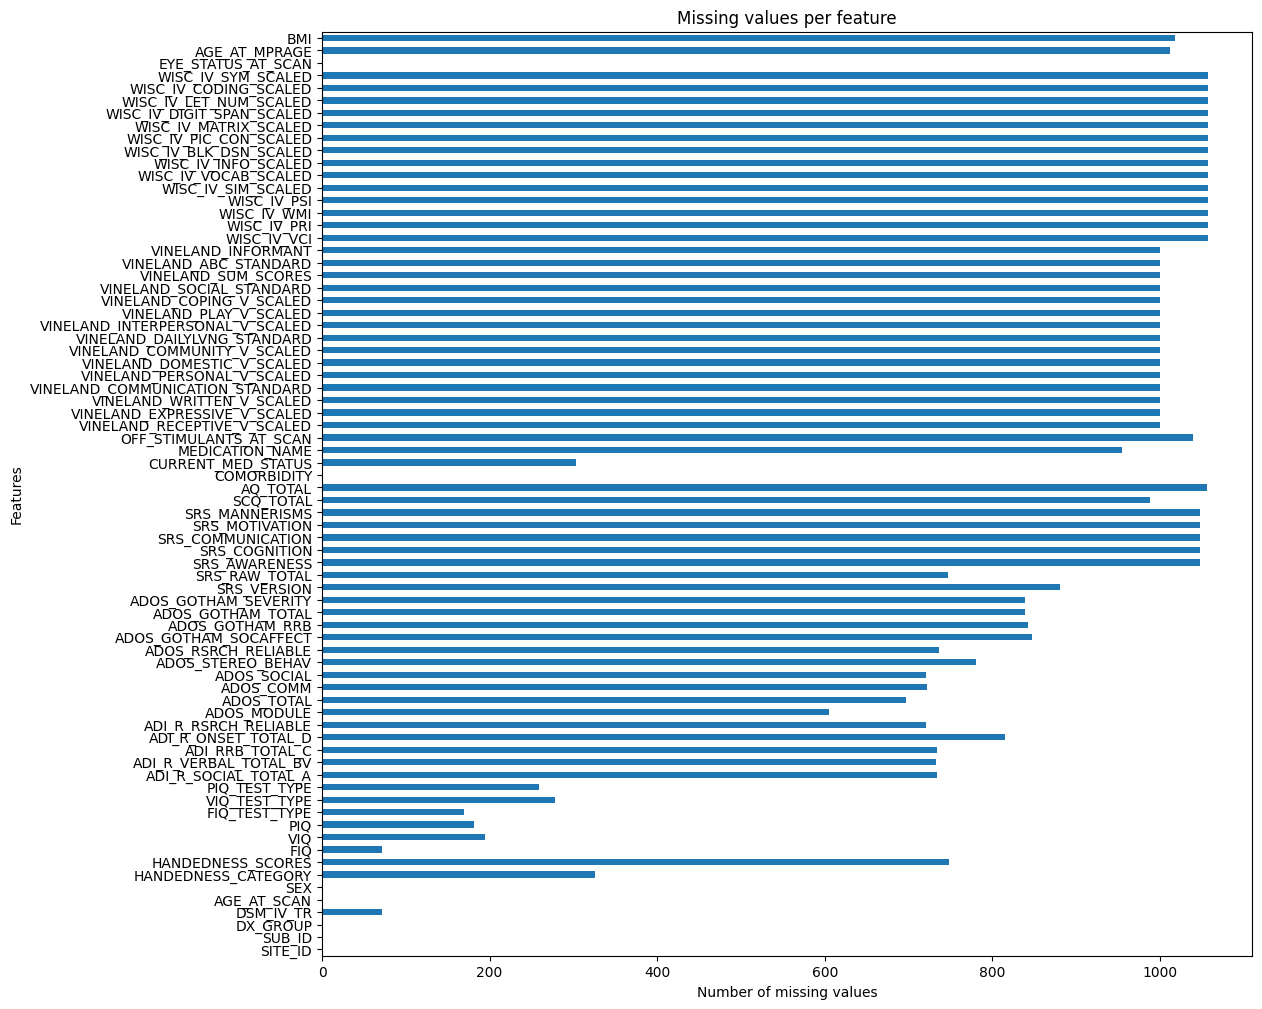

In [66]:
nan_values.plot(kind='barh', figsize=(12,12), title='Missing values per feature')
plt.xlabel('Number of missing values')
plt.ylabel('Features')
plt.show()

Is there some attribute with only missing values?

In [67]:

columns_only_nan = nan_values[nan_values == ASD_phenotypic.shape[0]]
print(len(columns_only_nan))

0


As there are too much, maybe is usefull to understand which columns haven't NaN values.

In [68]:
# Filter columns without NaN values
columns_without_nan = nan_values[nan_values == 0]

# Print the columns with NaN values and their corresponding counts
print("Attributes without NaN values and their counts:")
columns_without_nan

Attributes without NaN values and their counts:


SITE_ID               0
SUB_ID                0
DX_GROUP              0
AGE_AT_SCAN           0
SEX                   0
COMORBIDITY           0
EYE_STATUS_AT_SCAN    0
dtype: int64

There are maybe some subjects that has only missing values?

Max missing values encountered for a subject: 64
Min missing values encountered for a subject: 22


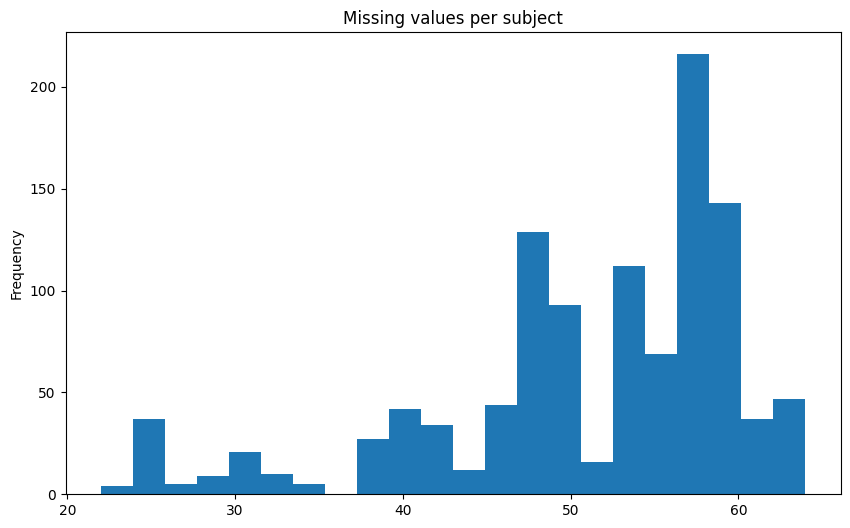

In [69]:
nan_values = ASD_phenotypic.T.isna().sum()

# Filter columns with NaN values
subjects_with_nan = nan_values[nan_values > 0]

print("Max missing values encountered for a subject: " +str(max(subjects_with_nan)))
print("Min missing values encountered for a subject: " +str(min(nan_values)))
subjects_with_nan.plot(kind='hist', bins=22, figsize=(10,6), title='Missing values per subject')
plt.show()


Let's have a look on the general statistics for the numerical attributes.

In [70]:
ASD_phenotypic.describe()

,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_INTERPERSONAL_V_SCALED,VINELAND_PLAY_V_SCALED,VINELAND_COPING_V_SCALED,VINELAND_SOCIAL_STANDARD,VINELAND_SUM_SCORES,VINELAND_ABC_STANDARD,VINELAND_INFORMANT,WISC_IV_VCI,WISC_IV_PRI,WISC_IV_WMI,WISC_IV_PSI,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
count,1112.000000,1112.000000,1040.000000,1112.000000,1112.000000,786.000000,364.000000,1040.000000,917.000000,931.000000,378.000000,379.000000,378.000000,297.000000,391.000000,507.000000,415.000000,390.000000,391.000000,331.000000,376.000000,265.000000,270.000000,273.000000,273.000000,231.000000,365.000000,64.000000,64.000000,64.000000,64.00000,64.000000,124.000000,56.000000,72.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,1112.000000,100.000000,94.000000
mean,50752.684353,1.515288,0.639423,17.048864,1.147482,79.134860,60.567225,108.380962,107.812432,106.625134,19.767196,15.791557,6.084656,3.218855,0.910486,3.341223,11.062651,3.553846,7.539642,1.921450,0.928191,9.071698,2.840741,11.912088,6.758242,1.199134,57.882192,7.546875,10.000000,17.406250,10.37500,8.937500,11.596774,21.910714,0.333333,12.883929,13.035714,14.250000,90.008929,13.991071,12.500000,14.580357,91.446429,11.928571,12.616071,14.794643,89.089286,272.035714,89.187500,1.035714,112.109091,106.618182,100.690909,96.690909,12.381818,11.818182,12.127273,11.636364,9.909091,11.545455,10.127273,10.363636,8.763636,9.890909,1.312050,12.951700,20.519255
std,447.680666,0.499991,0.828849,8.036419,0.354745,58.840297,47.495811,15.072062,16.244305,15.339533,5.527245,4.633822,2.577855,1.261132,0.285850,0.498948,4.638208,1.750776,3.337870,1.619912,0.258515,4.223688,1.857519,5.321948,2.486762,0.400216,42.799043,4.120909,7.690439,12.852915,7.54142,7.028005,9.602608,11.045817,0.474713,3.256997,3.616600,2.927041,20.313975,3.123568,3.257701,3.344050,17.156849,3.988077,4.020769,3.785078,23.033291,58.131093,19.839233,0.186411,17.142834,13.967543,15.143600,14.309894,3.094146,3.646870,3.103490,3.014555,3.187201,2.651472,3.232099,2.914610,2.821634,2.753266,0.463539,2.193555,5.244446
min,50002.000000,1.000000,0.000000,6.470000,1.000000,-100.000000,-100.000000,41.000000,42.000000,37.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,7.000000,0.000000,7.000000,6.000000,9.000000,40.000000,7.000000,2.000000,4.000000,42.000000,1.000000,1.000000,6.000000,20.000000,128.000000,41.000000,1.000000,63.000000,79.000000,56.000000,68.000000,1.000000,1.000000,5.000000,4.000000,3.000000,7.000000,2.000000,2.000000,4.000000,1.000000,1.000000,8.290000,6.530000
25%,50354.750000,1.000000,0.000000,11.658575,1.000000,100.000000,52.750000,99.000000,98.000000,97.000000,16.000000,12.000000,4.000000,3.000000,1.000000,3.000000,8.0000

We need to handle missing values. But how?
Is really necessary to fullfill all of them? Can we maybe make some feature selection previously?


To make random forest for features selections

In [ ]:
'''# Assuming 'data' is your DataFrame and 'target' is your target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target']), data['target'], test_size=0.2, random_state=42)

# Convert categorical variables to numeric using one-hot encoding (if needed)
# For example:
# X_train = pd.get_dummies(X_train)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Optionally, visualize feature importances
# (e.g., create a bar plot with feature names on the x-axis and importance scores on the y-axis)'''

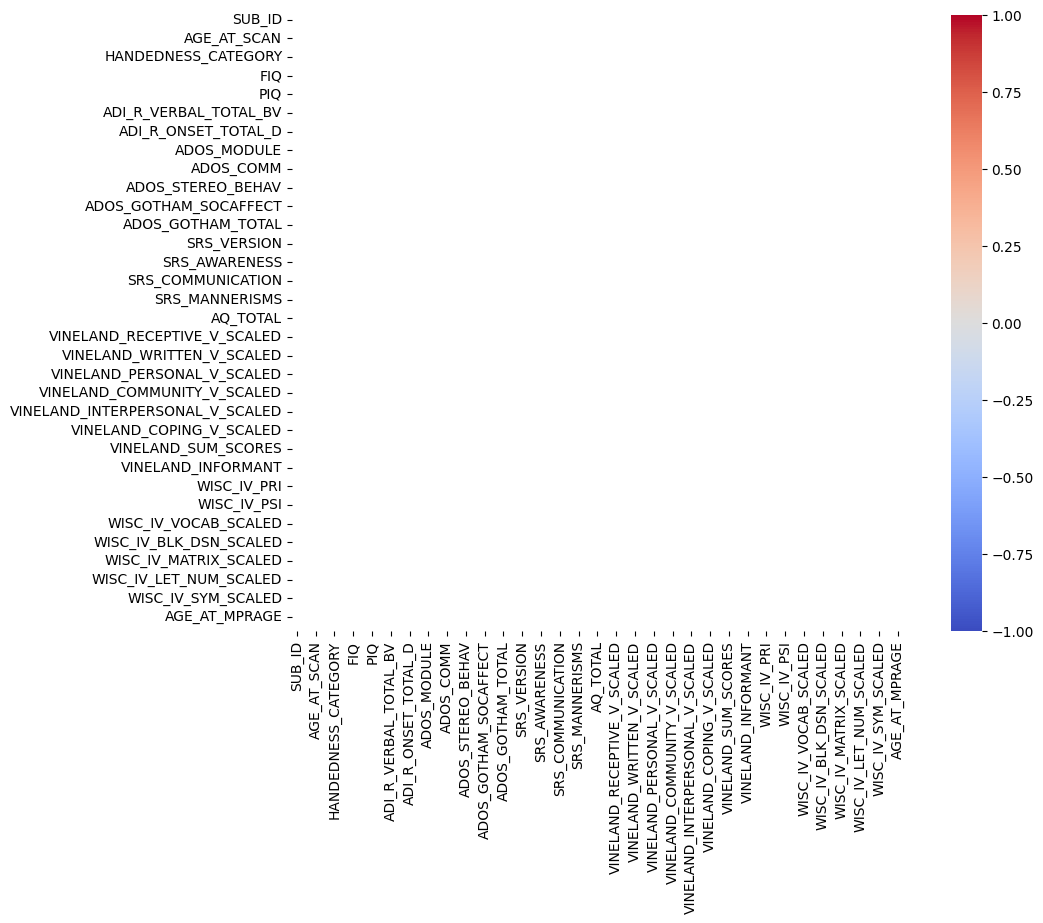

In [71]:
#vogliamo individuare e capire cosa sono questi object
numeric = ASD_phenotypic.select_dtypes(include=['float64',"int64"]).dropna()
numeric.T
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(numeric.drop('DX_GROUP',axis = 1).corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()

Drop attribute if:
- Only unique values
- Only missing values